In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Final Model


In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, AveragePooling2D, BatchNormalization, Permute, ReLU, Softmax
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt

In [ ]:
labels_to_include = ['snore', 'no_snore']
def determine_max_length(directory, labels_to_include, window_size, stride, n_mels):
    max_length = 0
    for label in labels_to_include:
        label_dir = os.path.join(directory, label)
        for file in os.listdir(label_dir):
            if file.lower().endswith('.wav'):
                file_path = os.path.join(label_dir, file)
                audio, sr = librosa.load(file_path, sr=None)
                hop_length = int(sr * stride)
                n_fft = int(sr * window_size)
                S = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
                if S.shape[1] > max_length:
                    max_length = S.shape[1]
    return max_length

In [ ]:
def Data_preprocess(directory, labels_to_include, window_size=0.03, stride=0.02, n_mels=40, max_length=None):
    labels = []
    spectrograms = []
    if max_length is None:
        max_length = calculate_max_length(directory, labels_to_include, window_size=0.03, stride=0.02, n_mels=40)

    for label in os.listdir(directory):
        if label in labels_to_include:
            label_dir = os.path.join(directory, label)
            for file in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file)
                audio, sr = librosa.load(file_path, sr=None)
                hop_length = int(sr * stride)
                n_fft = int(sr * window_size)
                S = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
                log_S = librosa.power_to_db(S, ref=np.max)

                if log_S.shape[1] < max_length:
                    pad_width = max_length - log_S.shape[1]
                    log_S = np.pad(log_S, pad_width=((0, 0), (0, pad_width)), mode='constant')

                spectrograms.append(log_S)
                labels.append(label)

    return np.array(spectrograms), np.array(labels)

In [ ]:
directory = '/content/drive/MyDrive/Snoring_Dataset'
labels_to_include = ['snore', 'no_snore']
max_length = determine_max_length(directory, labels_to_include, window_size=0.03, stride=0.02, n_mels=40)
spectrograms, labels = Data_preprocess(directory, labels_to_include, max_length=max_length)

In [ ]:
spectrograms.shape

(1000, 40, 51)

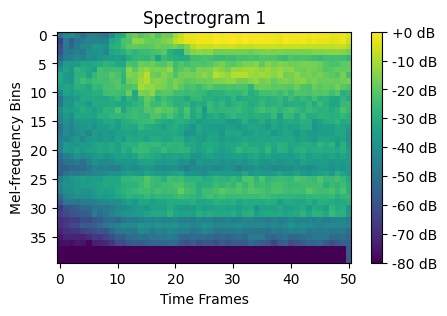

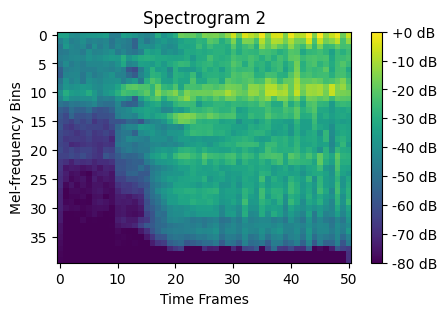

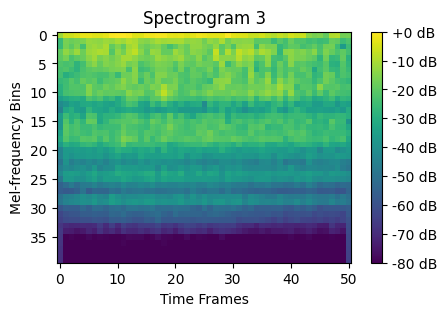

In [ ]:
for i in range(3):
    plt.figure(figsize=(5, 3))
    plt.imshow(spectrograms[i])
    plt.title(f"Spectrogram {i + 1}")
    plt.xlabel("Time Frames")
    plt.ylabel("Mel-frequency Bins")
    plt.colorbar(format='%+2.0f dB')
    plt.show()


In [ ]:
np.unique(labels)

array(['no_snore', 'snore'], dtype='<U8')

In [ ]:
#data preperation
spectrogram_shape = spectrograms[0].shape
num_classes = len(set(labels))

label_mapping = {label: idx for idx, label in enumerate(set(labels))}
numerical_labels = np.array([label_mapping[label] for label in labels])

spectrograms_reshaped = spectrograms.reshape(spectrograms.shape[0], spectrogram_shape[0], spectrogram_shape[1], 1)

In [ ]:
spectrograms_reshaped.shape, numerical_labels

In [ ]:
label_mapping

{'no_snore': 0, 'snore': 1}

In [ ]:
def create_model(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
# Splitting the data into training and testing sets
train_spectrograms, test_spectrograms, train_labels, test_labels = train_test_split(
    spectrograms_reshaped, numerical_labels, test_size=0.2, random_state=42)

In [ ]:
# Create the model
model = create_model(spectrogram_shape + (1,), num_classes)

In [ ]:
# Training the model and saving the history
history = model.fit(train_spectrograms, train_labels, epochs=10, validation_data=(test_spectrograms, test_labels))

Epoch 1/10
25/25 [==============================] - 11s 15ms/step - loss: 2.0706 - accuracy: 0.6075 - val_loss: 0.6088 - val_accuracy: 0.6400
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 0.5555 - accuracy: 0.6612 - val_loss: 0.5177 - val_accuracy: 0.6850
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 0.4428 - accuracy: 0.7800 - val_loss: 0.4285 - val_accuracy: 0.8500
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 0.3146 - accuracy: 0.8900 - val_loss: 0.3149 - val_accuracy: 0.8950
Epoch 5/10
25/25 [==============================] - 0s 5ms/step - loss: 0.2294 - accuracy: 0.9237 - val_loss: 0.2241 - val_accuracy: 0.9100
Epoch 6/10
25/25 [==============================] - 0s 6ms/step - loss: 0.1641 - accuracy: 0.9450 - val_loss: 0.2095 - val_accuracy: 0.9350
Epoch 7/10
25/25 [==============================] - 0s 6ms/step - loss: 0.0975 - accuracy: 0.9688 - val_loss: 0.1370 - val_accuracy: 0.9500
Epoch 8/10
25/25 [

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 49, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 19, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 11, 64)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 5632)              0         
                                                                 
 dense (Dense)               (None, 64)                3

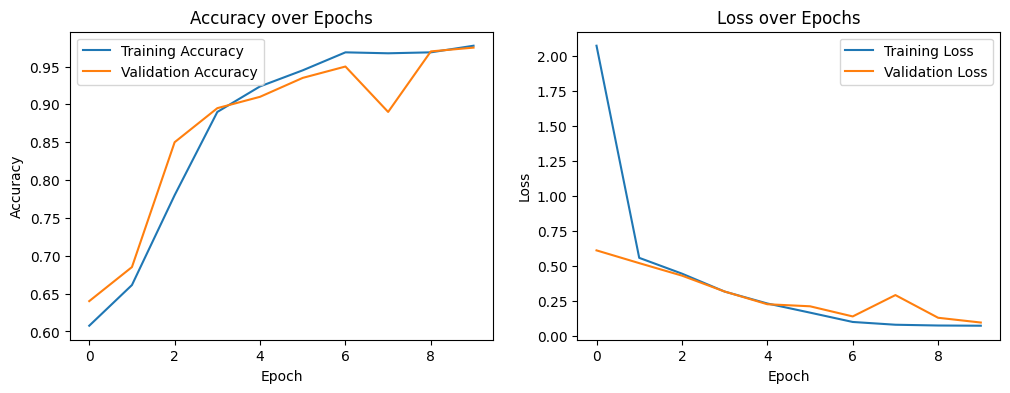

In [ ]:
# Plotting accuracy and loss graphs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_spectrograms, test_labels, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

7/7 - 0s - loss: 0.0934 - accuracy: 0.9750 - 33ms/epoch - 5ms/step
Test Accuracy: 97.50%


In [ ]:
# Predict and calculate per-class accuracies
predictions = model.predict(test_spectrograms)
predicted_classes = np.argmax(predictions, axis=1)
confusion_mtx = tf.math.confusion_matrix(test_labels, predicted_classes)

7/7 [==============================] - 0s 2ms/step


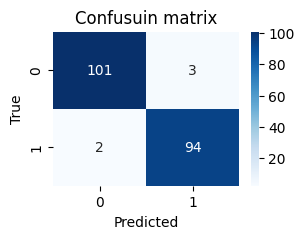

In [ ]:
import seaborn as sns
#plot confusion matrix
plt.figure(figsize=(3,2))
sns.heatmap(confusion_mtx, annot = True, fmt='d', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusuin matrix')
plt.show()

In [ ]:
# Calculate per-class accuracies
per_class_accuracy = tf.linalg.diag_part(confusion_mtx) / tf.reduce_sum(confusion_mtx, axis=1)
for label, acc in zip(label_mapping.keys(), per_class_accuracy):
    print(f"Accuracy for class {label}: {acc.numpy() * 100:.2f}%")

Accuracy for class no_snore: 97.12%
Accuracy for class snore: 97.92%


In [ ]:
# Save the model
model.save("model_final")

In [ ]:
# Load the saved model
model = tf.keras.models.load_model("model_final")

# Set up the converter with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_quantized_model = converter.convert()


In [ ]:
# Save the quantized model
with open("model_final.tflite", "wb") as f:
    f.write(tflite_quantized_model)


In [ ]:
model_size = os.path.getsize("model_final")
print(f"Model Size: {model_size:.2f} KB")

Model Size: 4096.00 KB
